# Нейронные сети








# Модификации градиентного спуска

.  
1. варианты решения задачи оптимизации для ML [https://education.yandex.ru/handbook/ml/article/optimizaciya-v-ml]
2. scikit-learn SGD [https://scikit-learn.org/stable/modules/sgd.html]
3. scikit-learn нейросети [https://scikit-learn.org/stable/modules/neural_networks_supervised.html]


**Обратное распространение ошибки:**

1. описание модели и данных: число эпох, веса, скорость обучения, разделение данных на тест, валидацию и тренировку

2. Подготовка тренировочных данных

3. Обученние нейронной сети

3.1. прямое распространение(feed forward)

3.2. оценка ошибки на выходе

3.3.1 получение значения производной активационнной функции текущего слоя

3.3.2 получение оценки ошибки на выходе предшествующего слоя

3.3.3 **коррекция весов текущего слоя**

3.3.4 переход к предшествующему слою если он не является рецептивным , иначе конец шага 3.3

3.4 проверка числа эпох: если необходимое число эпох отработано, то конец шага 3., иначе вернуться к 3.1.

4. Оценка результатов на тестовом множестве




In [138]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.datasets import load_digits

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

# sklearn здесь только, чтобы разделить выборку на тренировочную и тестовую
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

##  реализация вариантов оптимизиции:

Нейрон для анализа - логистического типа. Определим основные функции для обработки:

- to_one_hot(Y) : преобразует значение в вектор по правилу one-hot-encoding ( пример при 10 классах, значение Y=4 переведем в вектор <0, 0, 0, 0, 1, 0, 0, 0, 0, 0 >),

- from_one_hot(Y) : переводит вектор one-hot-encoding в значение скалярного типа (вектор Y <0, 0, 0, 0, 1, 0, 0, 0, 0, 0 > переводится в значение 4)

- sum_neuron(x=None, w=None) : вернет свертку векторов x, w - на выходе скалярное значение - внутреннее состояние нейрона,

-  sigmoid_complex_neuron(x = None, w = None, bias=0, lymbd = 1) : логистический нейрон с входным набором значений х  и настраиваемыми параметрами w.

- sigmoid_deriv(g) : производная логистического нейрона,

- normalize(X, axis=-1, order=2) : нормализация признаков - делаем входы удобными для нейрона
- standardsk(X) : стандартизация признаков

### **Задание 1**

1.1 реализовать функции to_one_hot(Y), from_one_hot(Y), sum_neuron(x=None, w=None), sigmoid_complex_neuron(x = None, w = None, bias=0, lymbd = 1), sigmoid_deriv(g), normalize(X, axis=-1, order=2), standardsk(X) для SGD с учетом сдвига нейрона:
    

1.2 реализовать функции to_one_hot(Y), from_one_hot(Y), sum_neuron(x=None, w=None), sigmoid_complex_neuron(x = None, w = None, bias=0, lymbd = 1), sigmoid_deriv(g), normalize(X, axis=-1, order=2), standardsk(X) для SGD минипакетной обработкой  с учетом сдвига нейрона:

Идентично градиентному спуску

In [2]:
# 1.1-1.2
def to_one_hot(y):
    classes = y.max() + 1
    y_one_hot = np.eye(classes, dtype=int)
    return y_one_hot[y]

def from_one_hot(y):
    return np.argmax(y, axis=1)

def sum_neuron(x=None, w=None):
    return x @ w

def sigmoid_complex_neuron(x=None, w=None, bias=0, lymbd=1):
    z = sum_neuron(x, w) + bias
    return 1. / (1 + np.exp(-lymbd * z))

def sigmoid_deriv(z):
    return z * (1 - z)

def normalize(X, axis=-1, order=2):
    norm = np.linalg.norm(X, order, axis, keepdims=True)
    norm = np.where(norm == 0, 1, norm) 
    return X / norm

def standardsk(X):
    mean = np.mean(X, axis=0, keepdims=True)
    std = np.std(X, axis=0, keepdims=True)
    std = np.where(std == 0, 1, std)  
    return (X - mean) / std

### **Задание 2**

2.1. Реализовать цикл работы для обучения модели по обратному распространению ошибки на примере ирисов Фишера для SGD

2.2. визуализировать результаты

In [53]:
class NeuralNetwork2Layers:
    def __init__(self, input_size=4, output_size=3, lr=0.05, n_iters=100000, 
                 neuron_numb=5, lyambda=1, batch_size=1, clip_value=None, 
                 clip_norm=None, is_adam=False, beta1=0.9, beta2=0.999, 
                 epsilon=1e-8, seed=None):
        self.lr = lr
        self.n_iters = n_iters
        self.neuron_numb = neuron_numb
        self.lyambda = lyambda
        self.batch_size = batch_size
        self.clip_value = clip_value
        self.clip_norm = clip_norm
        self.is_adam = is_adam
        self.beta1, self.beta2 = beta1, beta2
        self.epsilon = epsilon

        if self.is_adam:
            self.init_adam()
        
        if seed is not None:
            np.random.seed(seed)
        
        self.w0 = 2 * np.random.random((input_size, neuron_numb)) - 1
        self.b0 = 2 * np.random.random((1, neuron_numb)) - 1
        self.w1 = 2 * np.random.random((neuron_numb, output_size)) - 1
        self.b1 = 2 * np.random.random((1, output_size)) - 1
        
        if seed is not None:
            np.random.seed(None)

    def init_adam(self):
        self.t = 0
        
        self.w0_m = np.zeros_like(self.w0)
        self.w1_m = np.zeros_like(self.w1)
        self.b0_m = np.zeros_like(self.b0)
        self.b1_m = np.zeros_like(self.b1)
        
        self.w0_v = np.zeros_like(self.w0)
        self.w1_v = np.zeros_like(self.w1)
        self.b0_v = np.zeros_like(self.b0)
        self.b1_v = np.zeros_like(self.b1)
    
    
    def get_loss(self, y_pred_proba, y):
        n = y.shape[0]
        return np.sum((y - y_pred_proba) ** 2) / n

    def clip_grad(self, dLdw):
        dLdw0, dLdw1, dLdb0, dLdb1 = dLdw
        dLdw_norm_func = lambda dLdw0, dLdw1, dLdb0, dLdb1: np.sqrt(np.sum(dLdw0**2) + np.sum(dLdw1**2) + \
                                                                    np.sum(dLdb0**2) + np.sum(dLdb1**2))
        
        if self.clip_value is not None:
            dLdw0 = np.clip(dLdw0, -self.clip_value, self.clip_value)
            dLdw1 = np.clip(dLdw1, -self.clip_value, self.clip_value)
            dLdb0 = np.clip(dLdb0, -self.clip_value, self.clip_value)
            dLdb1 = np.clip(dLdb1, -self.clip_value, self.clip_value)
        
        if self.clip_norm is not None:
            dLdw_norm = dLdw_norm_func(dLdw0, dLdw1, dLdb0, dLdb1)
            if dLdw_norm > self.clip_norm:
                scale = self.clip_norm / dLdw_norm
                dLdw0 = dLdw0 * scale
                dLdw1 = dLdw1 * scale
                dLdb0 = dLdb0 * scale
                dLdb1 = dLdb1 * scale
        
        return [dLdw0, dLdw1, dLdb0, dLdb1]
    
    def forward(self, x):
        layer0 = x
        layer1 = sigmoid_complex_neuron(layer0, self.w0, self.b0, self.lyambda)
        layer2 = sigmoid_complex_neuron(layer1, self.w1, self.b1, self.lyambda)
        return [layer0, layer1, layer2]
    
    def backward(self, layers, y):
        n = y.shape[0]
        layer0, layer1, layer2 = layers
        
        dLdlayer2 = -2 * (y - layer2) / n
        dlayer2dz2 = dLdlayer2 * sigmoid_deriv(layer2) * self.lyambda
        dLdw1 = layer1.T @ dlayer2dz2
        dLdb1 = np.sum(dlayer2dz2, axis=0, keepdims=True)
        
        dz2dlayer1 = dlayer2dz2 @ self.w1.T
        dlayer1dz1 = dz2dlayer1 * sigmoid_deriv(layer1) * self.lyambda
        dLdw0 = layer0.T @ dlayer1dz1
        dLdb0 = np.sum(dlayer1dz1, axis=0, keepdims=True)
        
        return [dLdw0, dLdw1, dLdb0, dLdb1]
    
    def step_sgd(self, dLdw):
        dLdw0, dLdw1, dLdb0, dLdb1 = dLdw
        self.w0 -= self.lr * dLdw0
        self.w1 -= self.lr * dLdw1
        self.b0 -= self.lr * dLdb0
        self.b1 -= self.lr * dLdb1

    def step_adam(self, dLdw):
        dLdw0, dLdw1, dLdb0, dLdb1 = dLdw
        self.t += 1
    
        self.w0_m = self.beta1 * self.w0_m + (1 - self.beta1) * dLdw0
        self.w1_m = self.beta1 * self.w1_m + (1 - self.beta1) * dLdw1
        self.b0_m = self.beta1 * self.b0_m + (1 - self.beta1) * dLdb0
        self.b1_m = self.beta1 * self.b1_m + (1 - self.beta1) * dLdb1
        
        self.w0_v = self.beta2 * self.w0_v + (1 - self.beta2) * (dLdw0 ** 2)
        self.w1_v = self.beta2 * self.w1_v + (1 - self.beta2) * (dLdw1 ** 2)
        self.b0_v = self.beta2 * self.b0_v + (1 - self.beta2) * (dLdb0 ** 2)
        self.b1_v = self.beta2 * self.b1_v + (1 - self.beta2) * (dLdb1 ** 2)
        
        w0_m_correct = self.w0_m / (1 - self.beta1 ** self.t)
        w1_m_correct = self.w1_m / (1 - self.beta1 ** self.t)
        b0_m_correct = self.b0_m / (1 - self.beta1 ** self.t)
        b1_m_correct = self.b1_m / (1 - self.beta1 ** self.t)
        
        w0_v_correct = self.w0_v / (1 - self.beta2 ** self.t)
        w1_v_correct = self.w1_v / (1 - self.beta2 ** self.t)
        b0_v_correct = self.b0_v / (1 - self.beta2 ** self.t)
        b1_v_correct = self.b1_v / (1 - self.beta2 ** self.t)
        
        self.w0 -= self.lr * w0_m_correct / (np.sqrt(w0_v_correct) + self.epsilon)
        self.w1 -= self.lr * w1_m_correct / (np.sqrt(w1_v_correct) + self.epsilon)
        self.b0 -= self.lr * b0_m_correct / (np.sqrt(b0_v_correct) + self.epsilon)
        self.b1 -= self.lr * b1_m_correct / (np.sqrt(b1_v_correct) + self.epsilon)

    def step(self, dLdw):
        if self.is_adam:
            self.step_adam(dLdw)
        else:
            self.step_sgd(dLdw)
    
    def fit(self, X_train, y_train):
        n = X_train.shape[0]
        errors = []
        
        for epoch in range(self.n_iters):
            indices = np.random.permutation(n)
            X_shuffled = X_train[indices]
            y_shuffled = y_train[indices]
            
            epoch_loss = 0
            for i in range(0, n, self.batch_size):
                x_batch = X_shuffled[i:i+self.batch_size]
                y_batch = y_shuffled[i:i+self.batch_size]
                
                layers = self.forward(x_batch)
                loss = self.get_loss(layers[2], y_batch)
                epoch_loss += loss * x_batch.shape[0]
                
                dLdw = self.backward(layers, y_batch)
                dLdw_clipped = self.clip_grad(dLdw)

                self.step(dLdw_clipped)
            
            errors.append(epoch_loss / n)
        
        return errors
    
    def predict_proba(self, x):
        layers = self.forward(x)
        return layers[2]
    
    def predict(self, x):
        predict_proba = self.predict_proba(x)
        return np.argmax(predict_proba, axis=1)

In [48]:
data = load_iris()

x = data['data']
x = standardsk(x)  

y = data['target']
y = to_one_hot(y)  

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

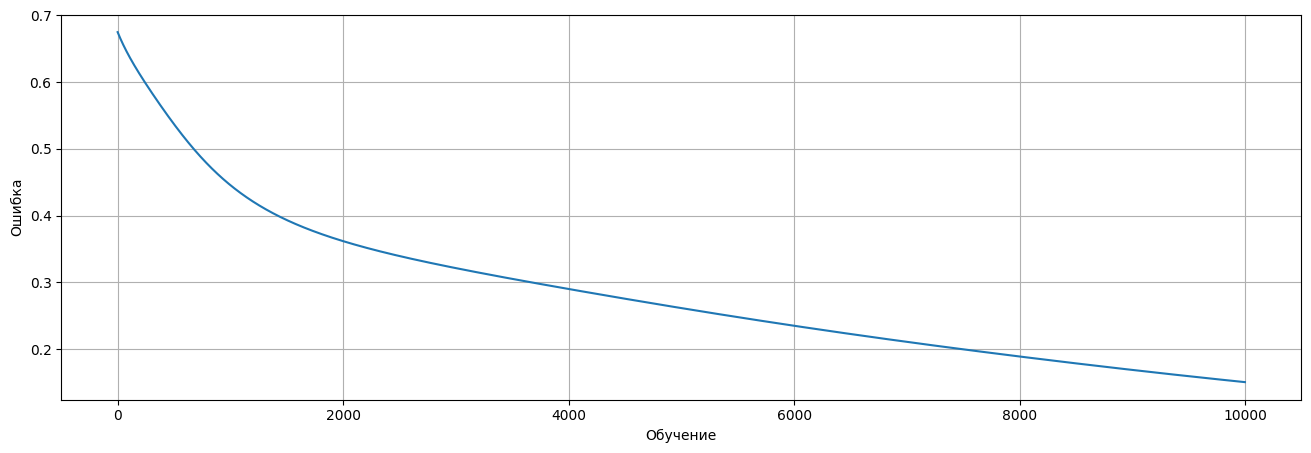

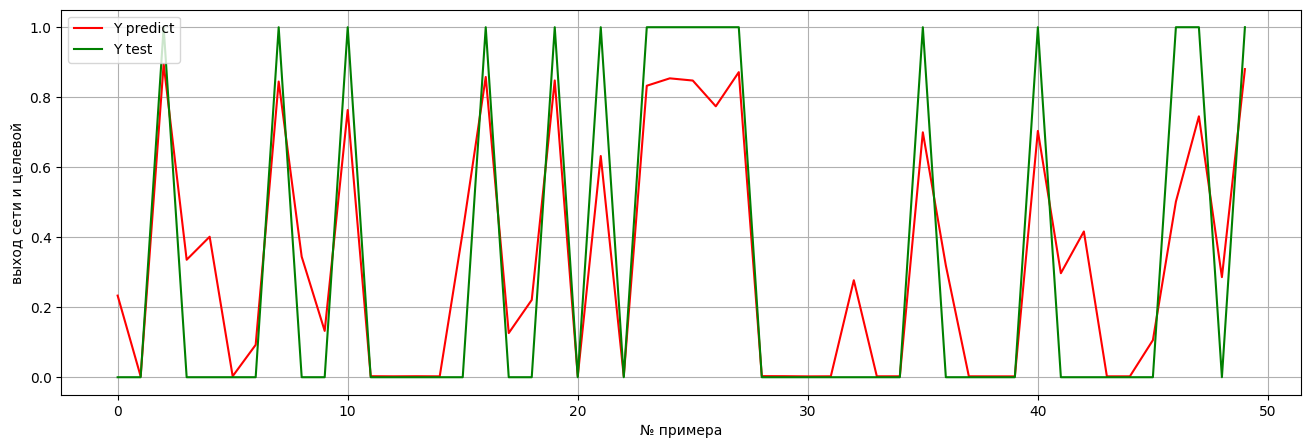

качество работы нейронной сети GD: 84.25%


In [49]:
# GD
model_gd = NeuralNetwork2Layers(
    input_size=4,
    output_size=3,
    lr=0.05,
    n_iters=10000,
    neuron_numb=5,
    lyambda=0.590,
    batch_size=len(X_train),  
    seed=42
)

errors = model_gd.fit(X_train, y_train)

plt.figure(figsize=(16, 5))
plt.plot(errors)
plt.xlabel("Обучение")
plt.ylabel("Ошибка")
plt.grid()
plt.show()  

layer2 = model_gd.predict_proba(X_test)
layer2_error = y_test - layer2
layer2_error = np.mean(np.abs(layer2_error))
N = 50

plt.figure(figsize=(16, 5))
plt.plot(layer2[:N, 2], "r", label="Y predict")
plt.plot(y_test[:N, 2], "g", label="Y test")
plt.xlabel("№ примера")
plt.ylabel("выход сети и целевой")
plt.legend()
plt.grid()
plt.show()  

#y_pred_test = model_gd.predict(X_test)
#y_test_labels = from_one_hot(y_test) 
#quality = accuracy_score(y_test_labels, y_pred_test) * 100
quality = (1 - layer2_error) * 100

print("качество работы нейронной сети GD: " + str(round(quality, 2)) + "%")

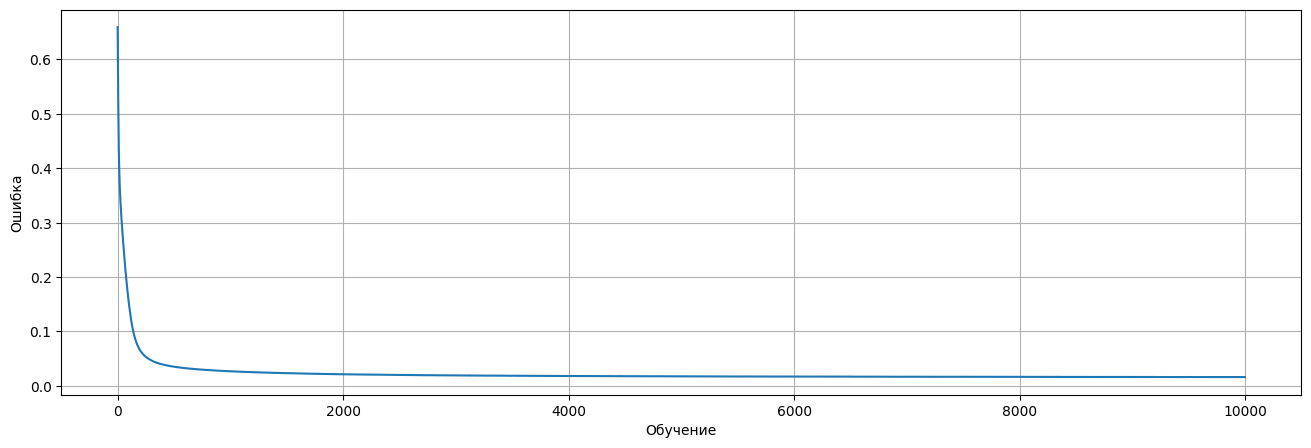

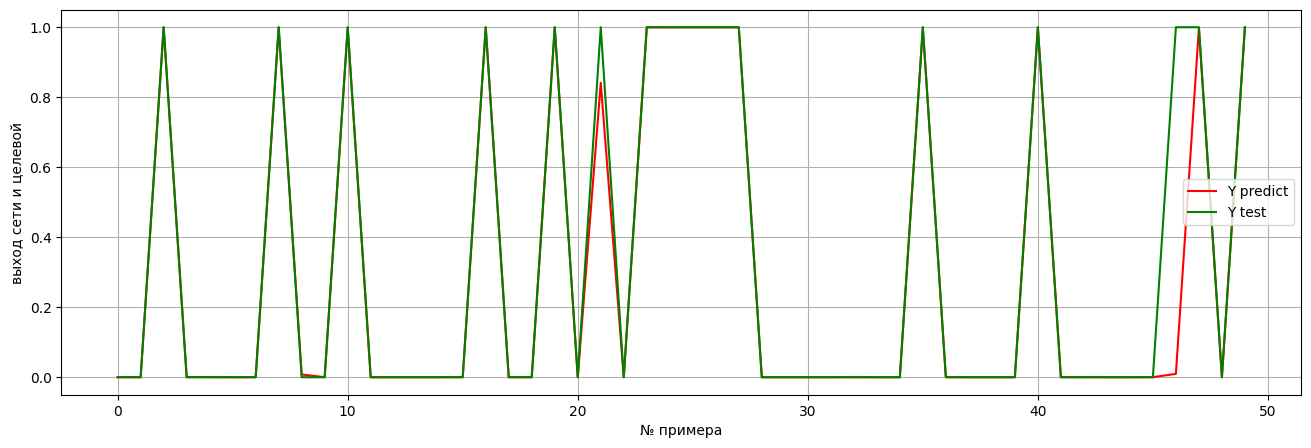

качество работы нейронной сети SGD: 98.22%


In [50]:
# SGD
model_sgd = NeuralNetwork2Layers(
    input_size=4,
    output_size=3,
    lr=0.05,
    n_iters=10000,
    neuron_numb=5,
    lyambda=0.590,
    batch_size=1,  
    seed=42
)

errors = model_sgd.fit(X_train, y_train)

plt.figure(figsize=(16, 5))
plt.plot(errors)
plt.xlabel("Обучение")
plt.ylabel("Ошибка")
plt.grid()
plt.show()  

layer2 = model_sgd.predict_proba(X_test)
layer2_error = y_test - layer2
layer2_error = np.mean(np.abs(layer2_error))
N = 50

plt.figure(figsize=(16, 5))
plt.plot(layer2[:N, 2], "r", label="Y predict")
plt.plot(y_test[:N, 2], "g", label="Y test")
plt.xlabel("№ примера")
plt.ylabel("выход сети и целевой")
plt.legend()
plt.grid()
plt.show()  

#y_pred_test = model_gd.predict(X_test)
#y_test_labels = from_one_hot(y_test) 
#quality = accuracy_score(y_test_labels, y_pred_test) * 100
quality = (1 - layer2_error) * 100

print("качество работы нейронной сети SGD: " + str(round(quality, 2)) + "%")

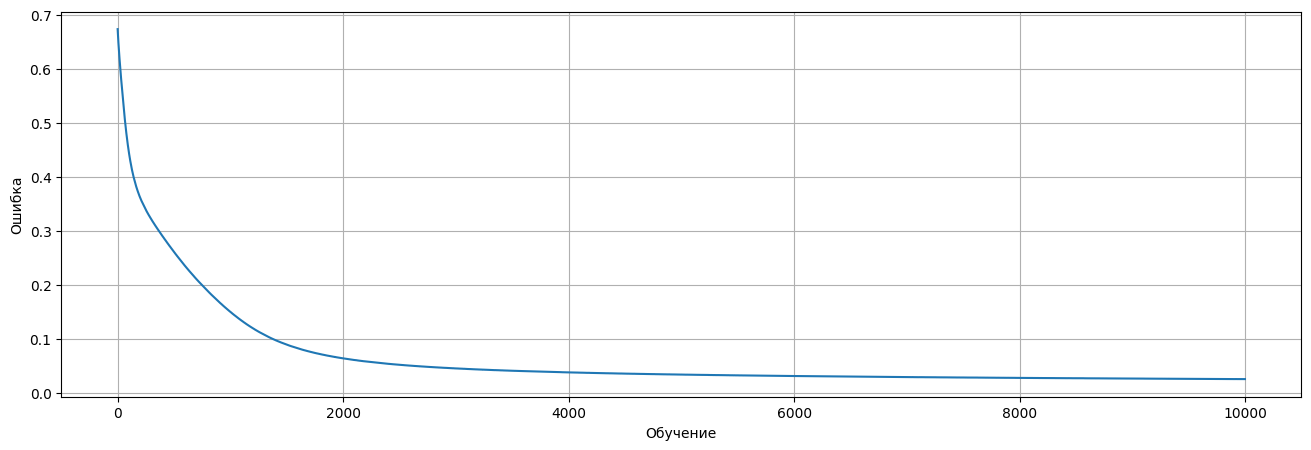

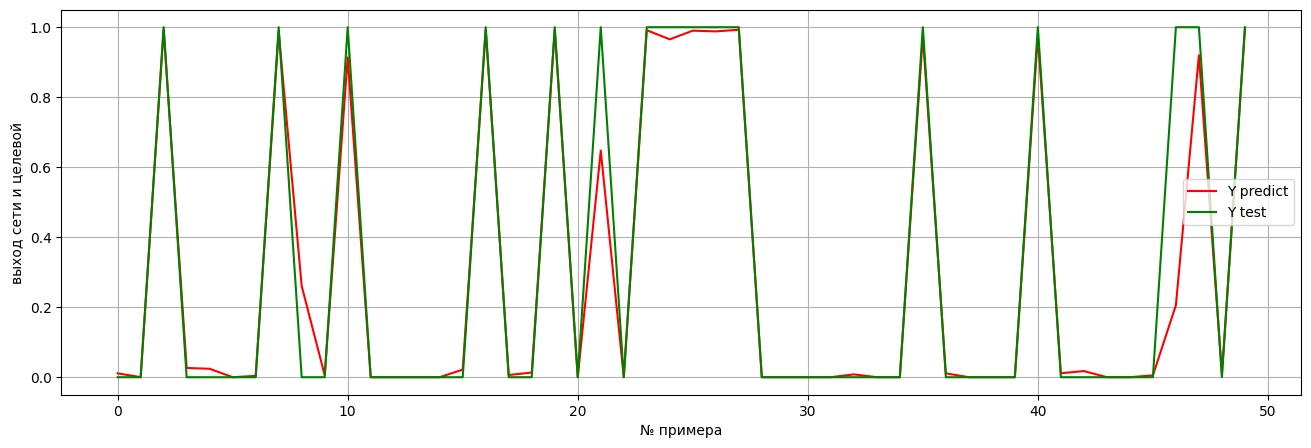

качество работы нейронной сети SGD: 96.64%


In [51]:
# SGD mini-batch
model_sgd_mb = NeuralNetwork2Layers(
    input_size=4,
    output_size=3,
    lr=0.05,
    n_iters=10000,
    neuron_numb=5,
    lyambda=0.590,
    batch_size=10,
    seed=42
)

errors = model_sgd_mb.fit(X_train, y_train)

plt.figure(figsize=(16, 5))
plt.plot(errors)
plt.xlabel("Обучение")
plt.ylabel("Ошибка")
plt.grid()
plt.show()  

layer2 = model_sgd_mb.predict_proba(X_test)
layer2_error = y_test - layer2
layer2_error = np.mean(np.abs(layer2_error))
N = 50

plt.figure(figsize=(16, 5))
plt.plot(layer2[:N, 2], "r", label="Y predict")
plt.plot(y_test[:N, 2], "g", label="Y test")
plt.xlabel("№ примера")
plt.ylabel("выход сети и целевой")
plt.legend()
plt.grid()
plt.show()  

#y_pred_test = model_gd.predict(X_test)
#y_test_labels = from_one_hot(y_test) 
#quality = accuracy_score(y_test_labels, y_pred_test) * 100
quality = (1 - layer2_error) * 100

print("качество работы нейронной сети SGD: " + str(round(quality, 2)) + "%")

Комментарий:
- GD : n = 0.05, lyambda = 0.0, batch =  100, n_1ter = 10000
- SGD : n = 0.05, lyambda = 0.59, batch =  1, , n_1ter = 100000
- SGD mini-batch : n = 0.05, lyambda = 0.9, batch = 10, n_1ter =10000

Задание - поизменять параметры в широких пределах : разделить на группы и посчитать среднее с разным seed одинаковым вариантам гиперпараметров

#### Вывод
- Для SGD получается наилучшая точность, однако время обучения у него самое большое – растёт с ростом n_iter. 
- У GD худшее качество, но самое быстрое время обучения.
- SGD mini-batch обучается не сильно дольше чем GD, а качество на 1% хуже чем у SGD, что делает эту модель лучшим вариантом.
- n_iter = 1000 для SGD уже даёт качество > 95%, когда у GD и SGD mini-batch < 90%.

## Обрезка градиента

### **Задание 3**

3.1. Реализовать цикл работы для обучения модели по оратному распространению ошибки на примере ирисов Фишера для SGD с обрезкой градиента

3.2. визуализировать результаты


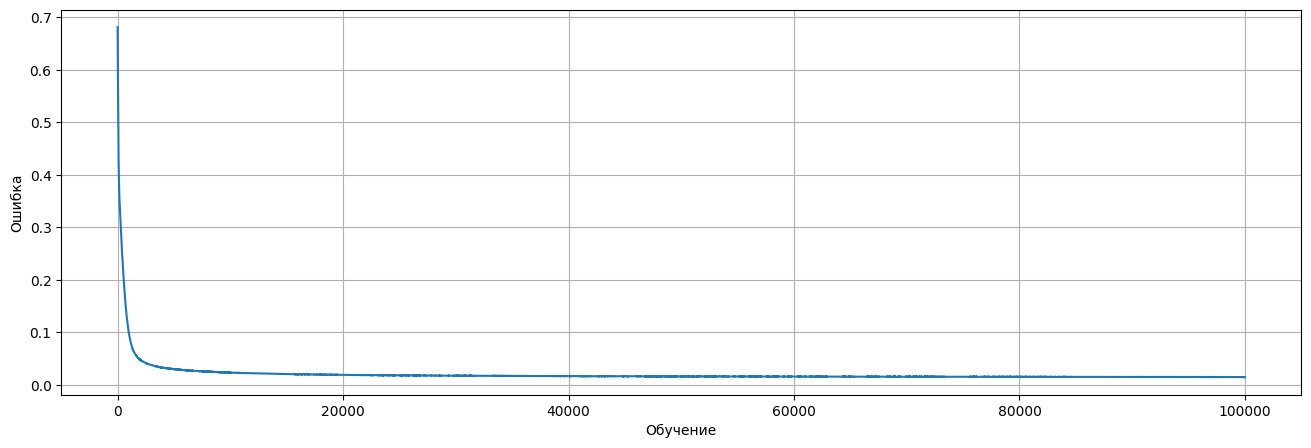

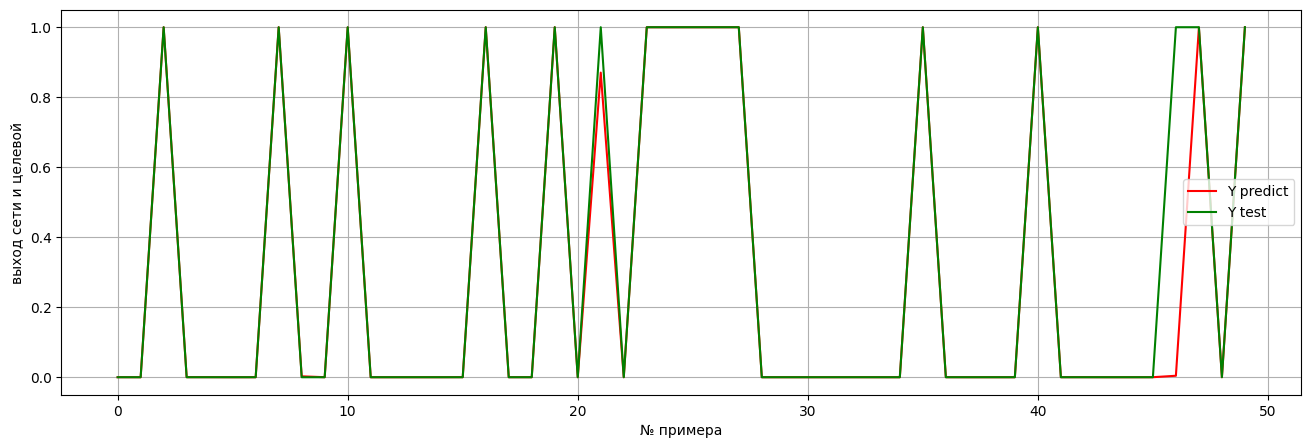

качество работы нейронной сети SGD mini-batch + обрезка градиента: 98.3%


In [52]:
# SGD mini-batch + обрезка градиента
model_clip = NeuralNetwork2Layers(
    input_size=4,
    output_size=3,
    lr=0.1,
    n_iters=100000,
    neuron_numb=5,
    lyambda=0.5,
    batch_size=10,
    clip_value=1.0,
    clip_norm=5.0,
    seed=42
)

errors = model_clip.fit(X_train, y_train)

plt.figure(figsize=(16, 5))
plt.plot(errors)
plt.xlabel("Обучение")
plt.ylabel("Ошибка")
plt.grid()
plt.show()  

layer2 = model_clip.predict_proba(X_test)
layer2_error = y_test - layer2
layer2_error = np.mean(np.abs(layer2_error))
N = 50

plt.figure(figsize=(16, 5))
plt.plot(layer2[:N, 2], "r", label="Y predict")
plt.plot(y_test[:N, 2], "g", label="Y test")
plt.xlabel("№ примера")
plt.ylabel("выход сети и целевой")
plt.legend()
plt.grid()
plt.show()  

#y_pred_test = model_gd.predict(X_test)
#y_test_labels = from_one_hot(y_test) 
#quality = accuracy_score(y_test_labels, y_pred_test) * 100
quality = (1 - layer2_error) * 100

print("качество работы нейронной сети SGD mini-batch + обрезка градиента: " + str(round(quality, 2)) + "%")

## Adam



### **Задание 4**

4.1. Реализовать цикл работы для обучения модели по оратному распространению ошибки на примере ирисов Фишера для ADAM

4.2. визуализировать результаты


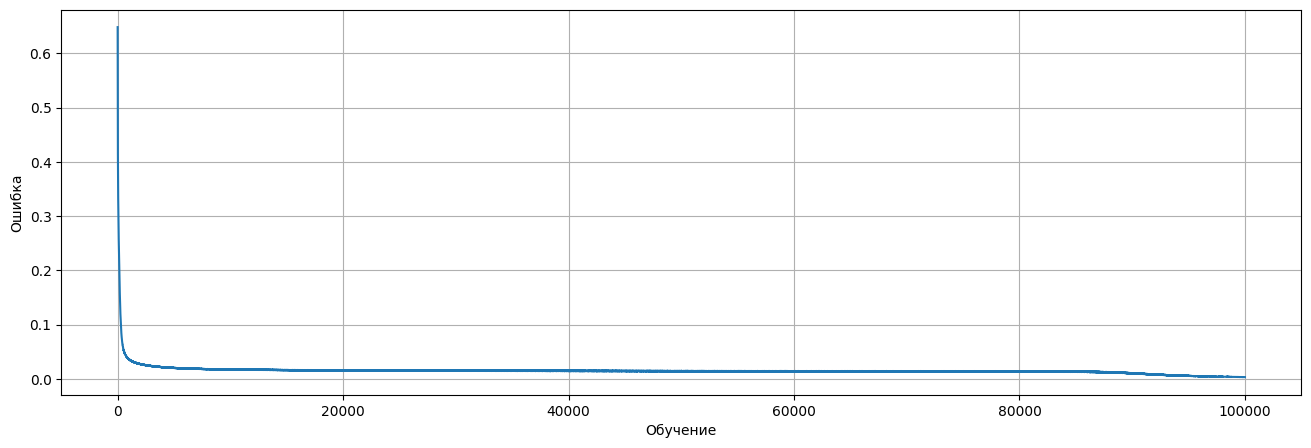

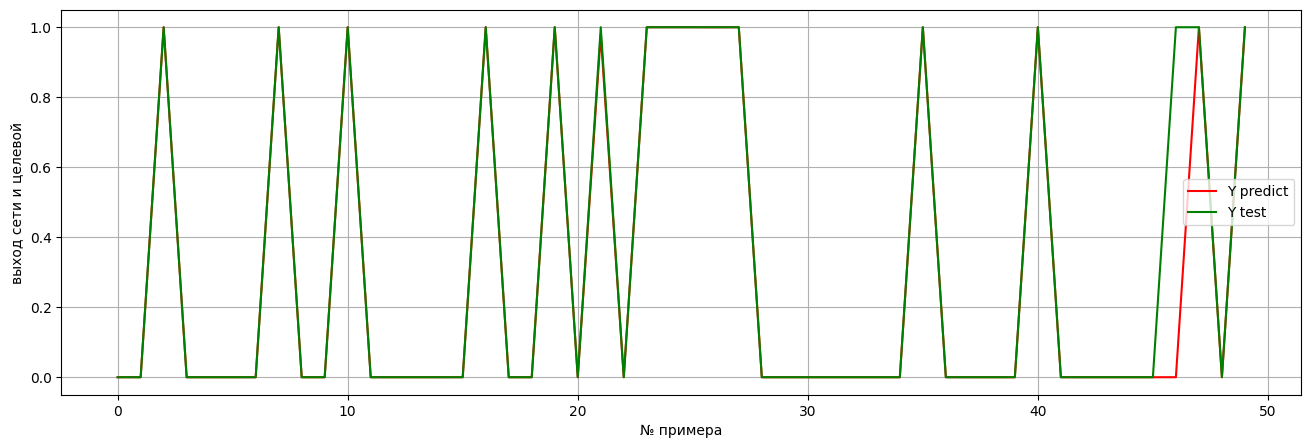

качество работы нейронной сети Adam mini-batch: 98.46%


In [55]:
# Adam mini-batch
model_adam = NeuralNetwork2Layers(
    input_size=4,
    output_size=3,
    lr=0.1,
    n_iters=100000,
    neuron_numb=5,
    lyambda=0.9,
    batch_size=10,
    #clip_value=1.0,
    #clip_norm=5.0,
    is_adam=False, 
    beta1=0.9, 
    beta2=0.5, 
    epsilon=0.01,
    seed=42
)

errors = model_adam.fit(X_train, y_train)

plt.figure(figsize=(16, 5))
plt.plot(errors)
plt.xlabel("Обучение")
plt.ylabel("Ошибка")
plt.grid()
plt.show()  

layer2 = model_adam.predict_proba(X_test)
layer2_error = y_test - layer2
layer2_error = np.mean(np.abs(layer2_error))
N = 50

plt.figure(figsize=(16, 5))
plt.plot(layer2[:N, 2], "r", label="Y predict")
plt.plot(y_test[:N, 2], "g", label="Y test")
plt.xlabel("№ примера")
plt.ylabel("выход сети и целевой")
plt.legend()
plt.grid()
plt.show()  

#y_pred_test = model_gd.predict(X_test)
#y_test_labels = from_one_hot(y_test) 
#quality = accuracy_score(y_test_labels, y_pred_test) * 100
quality = (1 - layer2_error) * 100

print("качество работы нейронной сети Adam mini-batch: " + str(round(quality, 2)) + "%")

In [56]:
import torch
from torch import nn

In [57]:
class Feedforward(nn.Module):
    def __init__(self, input_size, hidden_size, class_n=1):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, class_n)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [93]:
from sklearn.datasets import make_classification

x, y = make_classification(
    random_state=1,
    n_samples=5000,
    n_features=5,
    n_informative=2,
    n_redundant=3,
    shuffle=True,
)
# Разделение данных на тренировочные и тестовые
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

x_train = torch.FloatTensor(x_train)
y_train = torch.FloatTensor(y_train)
x_test = torch.FloatTensor(x_test)
y_test = torch.FloatTensor(y_test)

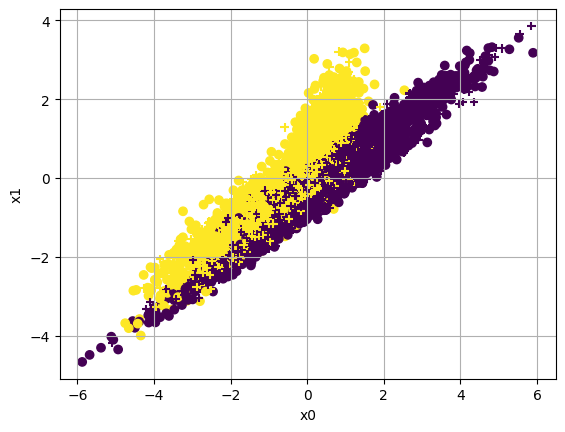

In [94]:
plt.scatter(x_train.numpy()[:, 0], x_train.numpy()[:, 1], c=y_train.numpy())
plt.scatter(x_test.numpy()[:, 0], x_test.numpy()[:, 1], c=y_test.numpy(), marker="+")
plt.grid()
plt.xlabel("x0")
plt.ylabel("x1")
plt.show()

In [95]:
from torch.utils.data import Dataset, DataLoader


class CustomDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, X, y):
        """
        Arguments:
            X - input
            y - label
        """
        self.X = X
        self.y = y
        self.m = X.mean(axis=0)
        self.s = X.std(axis=0)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = (
            torch.FloatTensor((self.X[idx, :] - self.m) / self.s),
            torch.FloatTensor(self.y[idx]),
        )

        return sample


training_data = CustomDataset(x_train, y_train)
test_data = CustomDataset(x_test, y_test)
train_dataloader = DataLoader(training_data, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=128, shuffle=False)

In [96]:
model = Feedforward(5, 1)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

Epoch 0: train loss: 0.6229677796363831
Epoch 100: train loss: 0.5597259402275085
Epoch 200: train loss: 0.4917477071285248
Epoch 300: train loss: 0.31785258650779724
Epoch 400: train loss: 0.34961190819740295
Epoch 500: train loss: 0.4113231897354126
Epoch 600: train loss: 0.326572984457016
Epoch 700: train loss: 0.3429631292819977
Epoch 800: train loss: 0.39845791459083557
Epoch 900: train loss: 0.44720545411109924
Epoch 1000: train loss: 0.3574499189853668
Epoch 1100: train loss: 0.2525847554206848
Epoch 1200: train loss: 0.41275811195373535
Epoch 1300: train loss: 0.4204549193382263
Epoch 1400: train loss: 0.40048837661743164
Epoch 1500: train loss: 0.36870524287223816
Epoch 1600: train loss: 0.23249661922454834
Epoch 1700: train loss: 0.41623371839523315
Epoch 1800: train loss: 0.23147420585155487
Epoch 1900: train loss: 0.3531024754047394
Test loss after Training 0.3588070571422577


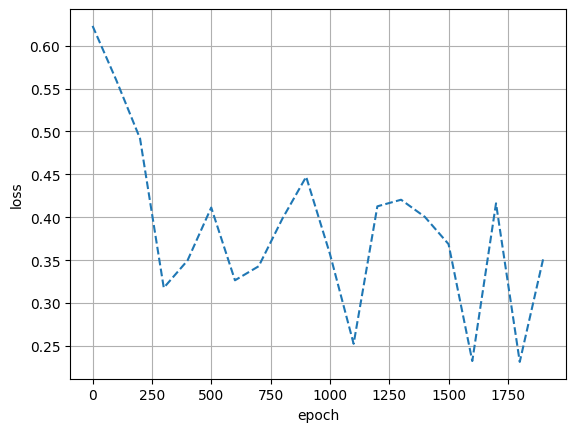

In [97]:
model.train()
epochs = 2000

rez_loss = []

for epoch in range(epochs):
    for data in train_dataloader:
        optimizer.zero_grad()

        x_t, y_t = data
        # Forward pass
        y_pred = model(x_t)

        # Compute Loss
        loss = criterion(y_pred.squeeze(), y_t)

        # Backward pass
        loss.backward()
        optimizer.step()

    if epoch % 100 == 0:
        print("Epoch {}: train loss: {}".format(epoch, loss.item()))
        rez_loss.append([epoch, loss.item()])

rez_loss = np.array(rez_loss)
plt.plot(rez_loss[:, 0], rez_loss[:, 1], "--", label="train")


model.eval()
y_pred = model(x_test)
after_test = criterion(y_pred.squeeze(), y_test)
print("Test loss after Training", after_test.item())

plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

Задание 5. собрать модель для ирисов Фишера

In [82]:
# 5. PyTorch модель для ирисов Фишера
data = load_iris()

x = data['data']  
y = data['target']
y = to_one_hot(y)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

training_data = CustomDataset(X_train, y_train)
test_data = CustomDataset(X_test, y_test)
train_dataloader = DataLoader(training_data, batch_size=10, shuffle=True)

In [83]:
model = Feedforward(4, 5, 3)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Epoch 0: train loss: 0.7134221196174622
Epoch 100: train loss: 0.24297279119491577
Epoch 200: train loss: 0.05041344091296196
Epoch 300: train loss: 0.06577493995428085
Epoch 400: train loss: 9.655683970777318e-05
Epoch 500: train loss: 0.01126337144523859
Epoch 600: train loss: 0.004346079658716917
Epoch 700: train loss: 0.0005746145034208894
Epoch 800: train loss: 0.22067682445049286
Epoch 900: train loss: 0.00011285898654023185
Epoch 1000: train loss: 0.0004660592239815742
Epoch 1100: train loss: 0.00026271073147654533
Epoch 1200: train loss: 0.0006934329285286367
Epoch 1300: train loss: 0.0005427881260402501
Epoch 1400: train loss: 0.0007589372689835727
Epoch 1500: train loss: 1.588808481756132e-05
Epoch 1600: train loss: 1.6111991499201395e-05
Epoch 1700: train loss: 0.00018359786190558225
Epoch 1800: train loss: 0.0009181015775538981
Epoch 1900: train loss: 0.0002441538672428578
Test loss after Training 0.011639110743999481


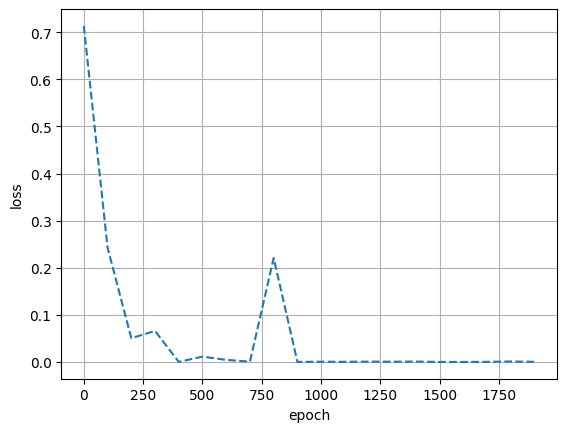

In [84]:
model.train()
epochs = 2000

rez_loss = []

for epoch in range(epochs):
    for data in train_dataloader:
        optimizer.zero_grad()

        x_t, y_t = data
        y_pred = model(x_t)
        loss = criterion(y_pred.squeeze(), y_t)
        loss.backward()
        optimizer.step()

    if epoch % 100 == 0:
        print("Epoch {}: train loss: {}".format(epoch, loss.item()))
        rez_loss.append([epoch, loss.item()])

rez_loss = np.array(rez_loss)
plt.plot(rez_loss[:, 0], rez_loss[:, 1], "--", label="train")

model.eval()
X_test_std = (X_test - training_data.m) / training_data.s
y_pred = model(X_test_std)

after_test = criterion(y_pred.squeeze(), y_test)
print("Test loss after Training", after_test.item())

plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

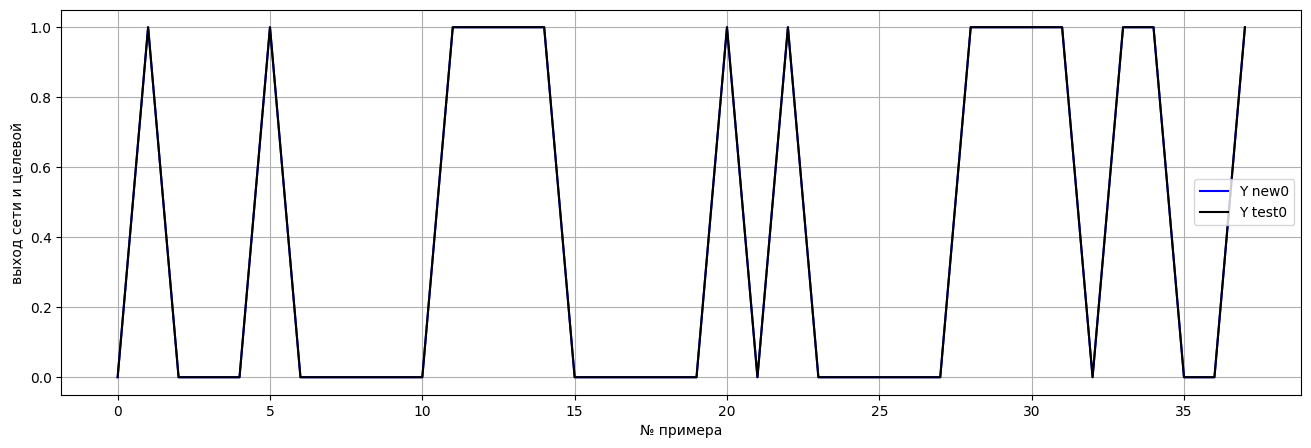

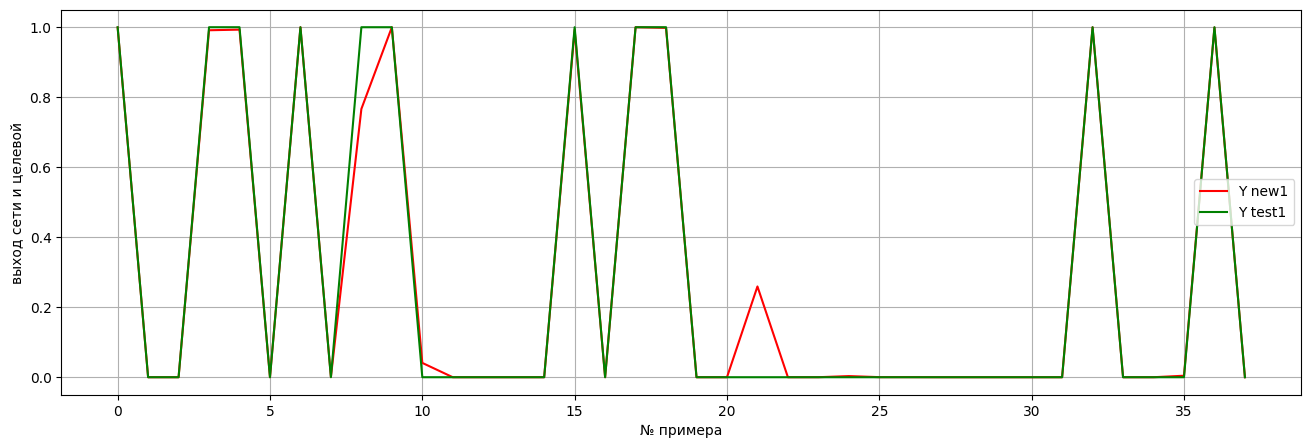

качество нейронной сети на тесте 98.98%


In [85]:
N = 50
plt.figure(figsize=(16, 5))

plt.plot(y_pred.cpu().detach().numpy()[:N, 0], "b", label="Y new0")
plt.plot(y_test.cpu().detach().numpy()[:N, 0], "k", label="Y test0")
plt.xlabel("№ примера")
plt.ylabel("выход сети и целевой")
plt.grid()
plt.legend()
plt.show()  # расскоментируйте, чтобы посмотреть
N = 50
plt.figure(figsize=(16, 5))
plt.plot(y_pred.cpu().detach().numpy()[:N, 1], "r", label="Y new1")
plt.plot(y_test.cpu().detach().numpy()[:N, 1], "g", label="Y test1")

plt.xlabel("№ примера")
plt.ylabel("выход сети и целевой")
plt.grid()
plt.legend()
plt.show()  

error_t = np.mean(np.abs((y_pred - y_test).cpu().detach().numpy()))
accuracy_t = (1 - error_t) * 100
print("качество нейронной сети на тесте " + str(round(accuracy_t, 2)) + "%")

## Практическое задание

Используем набор примеров load_digits

1.  Опишите - какой результата получен в нейросети в зависимости от:
  - числа нейронов в слое(для 2-хслойной сети),
  - шага обучения в диапазоне [10.0**(-5), 10.0].
  - фиксируйте для тренировочного и тестового набора метрики accuracy.
2. Сделайте вывод - что помогло вам улучшить качество классификации в нейросети на тестовом наборе?

3. Для одного варианта сетей сформируйте матрицу ошибок по классам. Оцените качество модели по каждому классу отдельно (полнота , точность). Сделайте вывод.

In [132]:
class Digitsforward(nn.Module):
    def __init__(self, input_size, hidden_size, class_n=10):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, class_n)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.log_softmax(x)
        return x

class DigitsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.m = X.mean(axis=0)
        self.s = X.std(axis=0)
        self.s[self.s == 0] = 1
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = (
            torch.FloatTensor((self.X[idx, :] - self.m) / self.s),
            torch.LongTensor([int(self.y[idx])]).squeeze(),  
        )
        return sample

def train(model, train_loader, criterion, optimizer, epochs):
    model.train()
    losses = []
    
    for epoch in range(epochs):
        epoch_loss = 0
        n_batches = 0
        
        for data in train_loader:
            optimizer.zero_grad()
            x_t, y_t = data
            
            y_pred = model(x_t)
            loss = criterion(y_pred, y_t)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            n_batches += 1
        
        avg_loss = epoch_loss / n_batches
        losses.append(avg_loss)
    
    return losses

def inference(model, X, y, training_data):
    model.eval()
    
    with torch.no_grad():
        X_std = (X - training_data.m) / training_data.s
        y_pred = model(X_std)
        y_pred_classes = torch.argmax(y_pred, dim=1).numpy()
    
    accuracy = accuracy_score(y.numpy(), y_pred_classes) * 100
    return accuracy

In [133]:
digits = load_digits()
x = digits['data']
y = digits['target']
x.shape

(1797, 64)

In [134]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.LongTensor(y_test)

training_data = DigitsDataset(X_train, y_train)

In [135]:
param_grid = {
    'hidden_size': [16, 32, 64],
    'lr': [0.01, 0.1, 0.05],
    'epochs': [1000, 2000, 4000]
}

best_acc = []
best_errors = []
best_params = []

for hidden_size in param_grid['hidden_size']:
    for lr in param_grid['lr']:
        for epochs in param_grid['epochs']:            
            train_loader = DataLoader(training_data, batch_size=128, shuffle=True)
            
            model = Digitsforward(input_size=64, hidden_size=hidden_size, class_n=10)
            criterion = nn.NLLLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            
            losses = train(model, train_loader, criterion, optimizer, epochs)

            acc_train = inference(model, X_train, y_train, training_data)
            acc_test = inference(model, X_test, y_test, training_data)
            
            if len(best_acc) == 0 or acc_test > best_acc[1]:
                best_acc = [acc_train, acc_test]
                best_errors = losses
                best_params = {
                    'hidden_size': hidden_size,
                    'lr': lr,
                    'epochs': epochs,
                    'final_loss': losses[-1]
                }

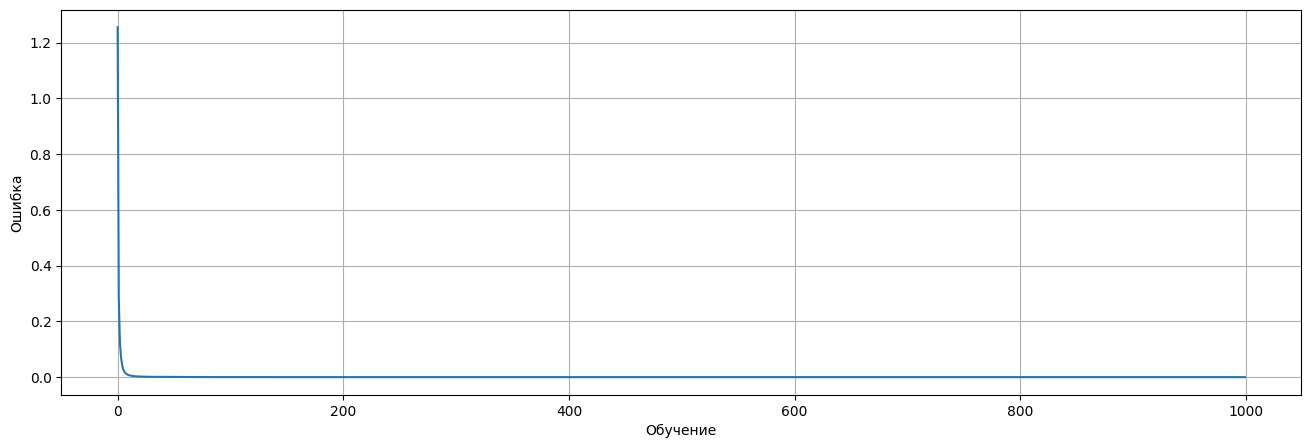

Аккуратность нейронной сети на тесте 98.44%
Аккуратность нейронной сети на трейне 100.0%
Лучшие параметры: lr=0.01, epochs=1000, hidden_size=64


In [136]:
plt.figure(figsize = (16,5))
plt.plot(best_errors)
plt.xlabel('Обучение')
plt.ylabel('Ошибка')
plt.grid()
plt.show()

print("Аккуратность нейронной сети на тесте " + str(round(best_acc[1],2)) + "%")
print("Аккуратность нейронной сети на трейне " + str(round(best_acc[0],2)) + "%")
print(f"Лучшие параметры: lr={best_params['lr']}, epochs={best_params['epochs']}, hidden_size={best_params['hidden_size']}")

#### Вывод о том, что помогло улучшить качество классификации
- Большее кол-во нейронов в скрытом слое позволяет модели учитывать больше число зависимостей во входных данных.
- При этом уже для 1000 эпох наступает плато и точность на тесте не увеличивается.
- lr для Adam нужен маленький, поэтому самый маленький lr даёт наилучшее качество

Для матрицы ошибок возьмём модель с наилучшими параметрами

In [137]:
best_model = Digitsforward(
    input_size=64, 
    hidden_size=best_params['hidden_size'], 
    class_n=10
)
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(best_model.parameters(), lr=best_params['lr'])

train_loader = DataLoader(training_data, batch_size=128, shuffle=True)
_ = train(best_model, train_loader, criterion, optimizer, best_params['epochs'])

best_model.eval()
with torch.no_grad():
    X_test_std = (X_test - training_data.m) / training_data.s
    y_pred_proba = best_model(X_test_std)
    y_pred = torch.argmax(y_pred_proba, dim=1).numpy()

y_test_labels = y_test.numpy()

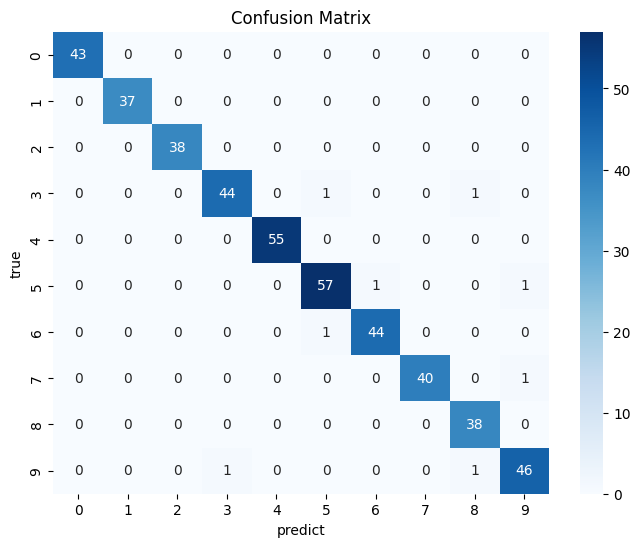

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        43
           1       1.00      1.00      1.00        37
           2       1.00      1.00      1.00        38
           3       0.98      0.96      0.97        46
           4       1.00      1.00      1.00        55
           5       0.97      0.97      0.97        59
           6       0.98      0.98      0.98        45
           7       1.00      0.98      0.99        41
           8       0.95      1.00      0.97        38
           9       0.96      0.96      0.96        48

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



In [139]:
cm = confusion_matrix(y_test_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('true')
plt.xlabel('predict')
plt.title(f'Confusion Matrix')
plt.show()

print(classification_report(y_test_labels, y_pred))

### Вывод по качеству модели
Нейронная сеть с 1 скрытым слоем отлично справилась с задачей. Минимальный precision = 0,95 модель имеет для цифры 8,
а минимальный recall = 0,96 для цифр 3 и 9. Значения точности и полноты для других цифр в среднем > 0,96 а матрица
ошибок по классам имеет диагональный вид. Всё это говорит о высокой точности модели для задачи предсказания цифр для датасета load_digits.
Причём PyTorch сеть вместе с Adam даёт результат лучше, чем сеть NeuralNetwork2Layers из дз №4.